In [1]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models, matutils
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import preprocessing, cluster
from ipyparallel import Client
from pymongo import MongoClient
import pandas as pd
import numpy as np
import requests
import json
import time
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Roger Ebert

In [ ]:
# roger ebert scraper
def get_roger(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    
    title = soup.find("h1", {"itemprop" : "name"}).text
    
    review_text = soup.find("div", {"itemprop" : "reviewBody"}).text
    
    site = "roger"
    
    score = int(float(soup.find("meta", {"itemprop" : "ratingValue"})['content']))
    
    return [title, review_text, site, score]

print get_roger("http://www.rogerebert.com/reviews/petes-dragon-2016")

### test scraping pages normally

In [ ]:
client = MongoClient()
db = client.review_db
reviews = db.review_col

headers = ['Title', 'Text', 'Site', 'Sentiment']

# up to page 412
for i in range(1, 2):
    url = "http://www.rogerebert.com/reviews/page/%d/" % i
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    for node in soup.find_all('a', {"class" : "poster"}):
        try:
            row_dict = dict(zip(headers, get_roger("http://www.rogerebert.com" + node['href'])))
            reviews.insert_one(row_dict)
        except:
            print "Error on page %d" % i
            continue
    if i % 50 == 0:
        print "Finished Iteration %d" % i
    time.sleep(3)

### scrape pages in parallel now

In [ ]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

@dv.parallel()
def dump_roger(it):
    from p4scrape import get_roger
    from bs4 import BeautifulSoup
    from pymongo import MongoClient
    import time, requests
    
    client = MongoClient()
    db = client.review_db
    reviews = db.review_col
    
    headers = ['Title', 'Text', 'Site', 'Score']
    for i in it:
        url = "http://www.rogerebert.com/reviews/page/%d/" % i
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, 'lxml')
        for node in soup.find_all('a', {"class" : "poster"}):
            try:
                row_dict = dict(zip(headers, get_roger("http://www.rogerebert.com" + node['href'])))
                reviews.insert_one(row_dict)
            except:
                print "Error on page %d" % i,
                continue
        if i % 50 == 0:
            print "Finished Iteration %d" % i
        time.sleep(3)

async = dump_roger(range(1, 413))

In [ ]:
print async.ready()
print async.stdout[0]
print async.elapsed

# 1595.012229 = 26 minutes

In [ ]:
print client.database_names()
print client.review_db.collection_names()
print client.review_db.review_col.count()

# The Guardian

In [2]:
# the guardian scraper
def get_guar(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    
    title = soup.find("h1", {"class" : "content__headline js-score"}).text
    title = re.search(r'(.*) review', title).group(1)
    
    review_text = soup.find("div", { "itemprop" : "reviewBody" }).text
    
    site = "guardian"
    
    raw_score = int(float(soup.find("span", {"itemprop" : "ratingValue"}).text))
    score = 4 if raw_score > 4 else raw_score
    
    return [title, review_text, site, score]

### test scraping pages normally

In [ ]:
client = MongoClient()
db = client.review_db
rev2 = db.rev_col2

headers = ['Title', 'Text', 'Site', 'Score']

# up to page 441
for i in range(1, 2):
    url = "https://www.theguardian.com/film+tone/reviews?page=%d" % i
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    for node in soup.find_all('a', {"class" : "u-faux-block-link__overlay js-headline-text"}):
        try:
            row_dict = dict(zip(headers, get_guar(node['href'])))
            print row_dict['Title']
            #rev2.insert_one(row_dict)
        except:
            print "Error on page %d" % i
            continue
    if i % 50 == 0:
        print "Finished Iteration %d" % i
    time.sleep(3)

### scraping pages in parallel now

In [7]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

@dv.parallel()
def dump_guardian(it):
    import requests, time, re
    from p4scrape import get_guar
    from bs4 import BeautifulSoup
    from pymongo import MongoClient
    
    client = MongoClient()
    db = client.review_db
    rev2 = db.rev_col2

    headers = ['Title', 'Text', 'Site', 'Score']
    for i in it:
        url = "https://www.theguardian.com/film+tone/reviews?page=%d" % i
        response = requests.get(url)
        page = response.text
        soup = BeautifulSoup(page, 'lxml')
        for node in soup.find_all('a', {"class" : "u-faux-block-link__overlay js-headline-text"}):
            try: # just skip movies without ratings
                row_dict = dict(zip(headers, get_guar(node['href'])))
                #print row_dict['Title']
                rev2.insert_one(row_dict)
            except:
                print "Error on page %d" % i
                continue
        if i % 50 == 0:
            print "Finished Iteration %d" % i
        time.sleep(3)

async = dump_guardian(range(1, 442))

In [ ]:
print async.ready()
print async.stdout[0]
print async.elapsed

# 2201.778616 = 36 minutes

In [ ]:
print client.database_names()
print client.review_db.collection_names()
print rev2.count()

# New York Times

In [115]:
# new york times scraper
def get_ny(url):
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    
    title = soup.find("h4", {"class" : "review-heading"}).text
    
    site = "new york"
    
    paragraphs = soup.find_all("p", {"class" : "story-body-text story-content"})
    review_text = " ".join(p.text for p in paragraphs)
    
    new_url = soup.find("div", {"class" : "imbd-details"}).a['href']
    response = requests.get(new_url)
    page = response.text
    soup = BeautifulSoup(page, 'lxml')
    score = int(float(soup.find("div", {"class" : "ratingValue"}).span.text))/2
    
    return [title, review_text, site, score]

### grab urls from infinite scroller

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

driver = webdriver.Chrome()
driver.get("http://www.nytimes.com/reviews/movies/")
driver.find_element(By.XPATH,'//*[@id="stream-search"]/div[3]/div/div/button').click()
driver.execute_script("window.scrollTo(0, -document.body.scrollHeight);")

urls = []
for i in range(400):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") # handle infinite scroller
    time.sleep(3)

web_obj = driver.find_elements(By.XPATH,'//a[@class="story-link"]')
for url in web_obj:
    urls.append(url.get_attribute('href'))
driver.close()

### save url list to json

In [3]:
import json

with open('urls.json', 'w') as f:
    json.dump(urls, f)

with open('urls.json', 'r') as f:
     urls = json.load(f)

url_list = zip(range(1,len(urls)+1), urls)

### scarping urls in parallel now

In [22]:
from ipyparallel import Client
rc = Client()
dv = rc[:]

@dv.parallel()
def dump_ny(urls):
    import requests, time, re
    from p4scrape import get_ny
    from bs4 import BeautifulSoup
    from pymongo import MongoClient
    
    client = MongoClient()
    db = client.review_db
    rev4 = db.rev_col4

    headers = ['Title', 'Text', 'Site', 'Score']
    for url in urls:
        i = url[0]
        try:
            row_dict = dict(zip(headers, get_ny(url[1])))
            rev4.insert_one(row_dict)
        except:
            print "Error on item %d" % i
            continue
        if i % 50 == 0:
            print "Finished Iteration %d" % i
        time.sleep(3)

async = dump_ny(url_list)

In [ ]:
print async.ready()
print async.stdout[0]
print async.elapsed

# 6185.70496 = 103 minutes = 1 hour 43 minutes

In [ ]:
client = MongoClient()
print client.database_names()
print client.review_db.collection_names()
print client.review_db.rev_col4.count()

# Read in and combine collections into data frame

In [3]:
df1 = pd.DataFrame(list(client.review_db.review_col.find()))
df2 = pd.DataFrame(list(client.review_db.rev_col2.find()))
df3 = pd.DataFrame(list(client.review_db.rev_col4.find()))

In [4]:
df = pd.concat([df1,df2,df3], axis=0)
df = df.drop('_id', axis=1)
df = df.reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19611 entries, 0 to 19610
Data columns (total 4 columns):
Score    19611 non-null int64
Site     19611 non-null object
Text     19611 non-null object
Title    19611 non-null object
dtypes: int64(1), object(3)
memory usage: 612.9+ KB


roger       0.501555
guardian    0.274846
new york    0.223599
Name: Site, dtype: float64


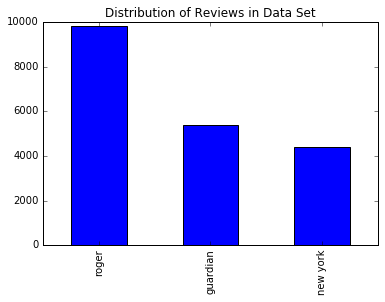

In [59]:
print df['Site'].value_counts(normalize=True)
df['Site'].value_counts().plot(kind='bar')
plt.title('Distribution of Reviews in Data Set');

In [64]:
from sklearn import cross_validation

X = df['Text']
y = df['Site']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25, random_state=42)

# Create features

### Tfidf and Bag of Words

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vectorizer = CountVectorizer(stop_words='english')

bow = cnt_vectorizer.fit_transform(X_train)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')

tfidf = vectorizer.fit_transform(X_train)

### LSA

In [8]:
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(10)
dtm_lsa = pd.DataFrame(lsa.fit_transform(tfidf))

In [ ]:
# most important words in each topic via SVD
sorted(zip(cnt_vectorizer.get_feature_names(), lsa.components_[2]), key=lambda x: x[1], reverse=True)

In [55]:
# average topic mixtures for each review site
print np.mean(dtm_lsa[y_train.reset_index(drop=True) == 'roger'], axis=0).reshape(1,-1)[0][:10]
print np.mean(dtm_lsa[y_train.reset_index(drop=True) == 'guardian'], axis=0).reshape(1,-1)[0][:10]
print np.mean(dtm_lsa[y_train.reset_index(drop=True) == 'new york'], axis=0).reshape(1,-1)[0][:10]

[ 0.16587528 -0.02484106  0.00096765]
[ 0.10102727  0.01008947 -0.02596334]
[ 0.12122129  0.0701629   0.01747415]


### Non-negative Matrix Factorization

In [10]:
from sklearn.decomposition import NMF

nmf = NMF(10)
dtm_nmf = pd.DataFrame(nmf.fit_transform(tfidf))

In [ ]:
# most important words in each topic via NMF
sorted(zip(cnt_vectorizer.get_feature_names(), nmf.components_[9]), key=lambda x: x[1], reverse=True)

In [217]:
# average topic mixtures for each review site
print np.mean(dtm_nmf[y_train.reset_index(drop=True) == 'roger'], axis=0).reshape(1,-1)[0]
print np.mean(dtm_nmf[y_train.reset_index(drop=True) == 'guardian'], axis=0).reshape(1,-1)[0]
print np.mean(dtm_nmf[y_train.reset_index(drop=True) == 'new york'], axis=0).reshape(1,-1)[0]

[ 0.01728114  0.0012568   0.01547245  0.00187586  0.01256139  0.014721
  0.00840142  0.00930353  0.01927683  0.00343213]
[ 0.00421911  0.00112363  0.01252601  0.00213813  0.00715713  0.00810688
  0.0074585   0.00520428  0.00646472  0.02742263]
[ 0.00559201  0.02884281  0.01237624  0.02324343  0.00941592  0.0076514
  0.00792885  0.00593226  0.00673444  0.00346404]


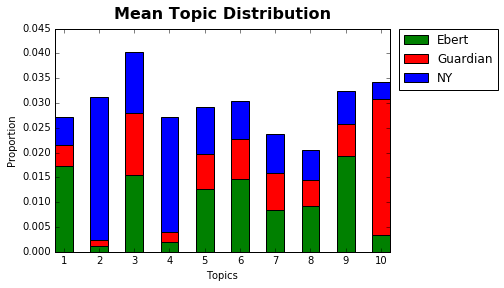

In [219]:
ind = np.arange(10)
width = 0.5
rog = np.mean(dtm_nmf[y_train.reset_index(drop=True) == 'roger'], axis=0).reshape(1,-1)[0][:10]
guar = np.mean(dtm_nmf[y_train.reset_index(drop=True) == 'guardian'], axis=0).reshape(1,-1)[0][:10]
nyk = np.mean(dtm_nmf[y_train.reset_index(drop=True) == 'new york'], axis=0).reshape(1,-1)[0][:10]
total = rog + guar + nyk

plt.bar(ind, rog, width, color='green', label='Ebert')
plt.bar(ind, guar, width, color='red', bottom=rog, label='Guardian')
plt.bar(ind, nyk, width, color='blue', bottom=rog+guar, label='NY')
plt.title('Mean Topic Distribution', fontweight='bold', fontsize=16, y=1.02)
plt.xlabel('Topics')
plt.ylabel('Proportion')
plt.xlim([0,9.5])
plt.xticks(np.arange(1,11)-width*1.5, np.arange(1,11))
plt.legend(bbox_to_anchor=(1.34, 1.025))
plt.show()

In [224]:
topic_df = pd.DataFrame({"topic": range(1, 11), "NY": 100*nyk/total, "Guardian": 100*guar/total, 
                         "Ebert": 100*rog/total})
topic_df.to_json("topics.json", orient="records")

In [225]:
with open("topics.json", 'r') as f:
    topics_json = json.load(f)
    
print pd.DataFrame(topics_json)

       Ebert   Guardian         NY  topic
0  63.786268  15.573103  20.640630      1
1   4.025221   3.598709  92.376070      2
2  38.322147  31.024412  30.653441      3
3   6.882017   7.844224  85.273759      4
4  43.115264  24.565880  32.318856      5
5  48.298387  26.597997  25.103616      6
6  35.316755  31.353020  33.330225      7
7  45.516148  25.461171  29.022681      8
8  59.357166  19.906156  20.736678      9
9  10.000732  79.905557  10.093711     10


### LDA

In [13]:
id2word = dict((v, k) for k, v in cnt_vectorizer.vocabulary_.iteritems())

corpus = matutils.Sparse2Corpus(bow, documents_columns=False)
lda = models.LdaModel(corpus, num_topics=3, id2word=id2word, passes=10)

In [14]:
lda.print_topics(num_words=50)

[(0,
  u'0.007*film + 0.005*like + 0.004*mr + 0.004*movie + 0.003*director + 0.003*just + 0.002*new + 0.002*life + 0.002*time + 0.002*ms + 0.002*story + 0.002*family + 0.002*young + 0.002*love + 0.002*mother + 0.002*comedy + 0.002*way + 0.002*self + 0.002*character + 0.002*old + 0.002*played + 0.001*characters + 0.001*year + 0.001*directed + 0.001*father + 0.001*does + 0.001*little + 0.001*makes + 0.001*plays + 0.001*sex + 0.001*rated + 0.001*make + 0.001*drama + 0.001*work + 0.001*home + 0.001*best + 0.001*woman + 0.001*world + 0.001*writer + 0.001*kind + 0.001*good + 0.001*doesn + 0.001*scene + 0.001*parents + 0.001*adult + 0.001*school + 0.001*women + 0.001*high + 0.001*son + 0.001*david'),
 (1,
  u'0.013*movie + 0.007*film + 0.007*like + 0.005*man + 0.004*time + 0.004*way + 0.004*story + 0.003*life + 0.003*good + 0.003*people + 0.003*characters + 0.003*doesn + 0.003*know + 0.003*little + 0.003*does + 0.003*scene + 0.003*just + 0.003*love + 0.003*movies + 0.002*make + 0.002*characte

In [19]:
# convert topic vectors into data frame columns
def topic2df(topic_vec, topic_num):
    topic_vec_list = []
    for row in topic_vec:
        d = dict(row)
        for i in range(topic_num):
            if i not in d:
                d[i] = 0
        topic_vec_list.append(d)
    topics = pd.DataFrame(topic_vec_list)
    topics.columns = ['t%d' % i for i in range(topic_num)]
    return topics

topic_vec = list(lda[corpus])
topics = topic2df(topic_vec, 3)

In [20]:
print topics.sample(10)
print

# average topic mixtures for each review site
print np.mean(topics[y_train.reset_index(drop=True) == 'roger'], axis=0).reshape(1,-1)
print np.mean(topics[y_train.reset_index(drop=True) == 'guardian'], axis=0).reshape(1,-1)
print np.mean(topics[y_train.reset_index(drop=True) == 'new york'], axis=0).reshape(1,-1)

             t0        t1        t2
13652  0.288044  0.036220  0.675736
8540   0.673582  0.325336  0.000000
10771  0.000000  0.670339  0.328130
11153  0.741384  0.000000  0.254616
10441  0.619808  0.286394  0.093798
8591   0.142221  0.323173  0.534606
11150  0.778500  0.193941  0.027559
7425   0.167905  0.830381  0.000000
7035   0.037295  0.898570  0.064135
6316   0.838714  0.155790  0.000000

[[ 0.13576757  0.70181643  0.16123351]]
[[ 0.49602977  0.15037988  0.35142461]]
[[ 0.48153292  0.16080821  0.35664188]]


### K-means clustering

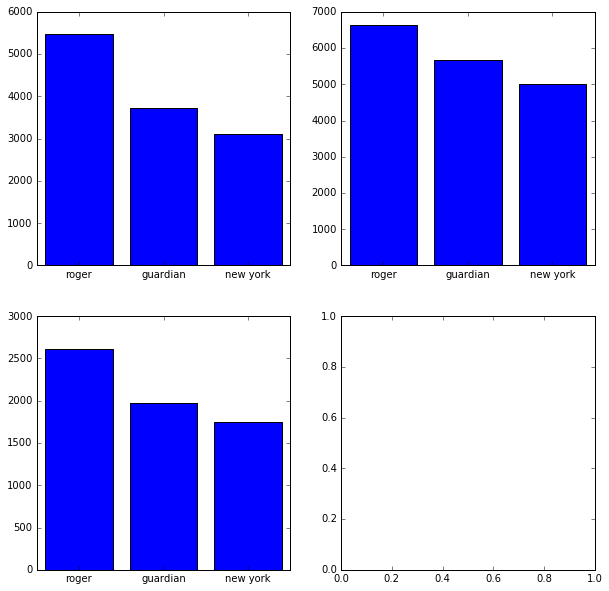

In [47]:
from sklearn import preprocessing, cluster

dtm_lsa = pd.DataFrame(preprocessing.Normalizer(copy=False).fit_transform(dtm_lsa))

cls = cluster.KMeans(n_clusters=3)
cls.fit(dtm_lsa)

clusters = cls.predict(dtm_lsa)
cls_num = np.unique(clusters)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
axes = ax.flat
for i, a in zip(cls_num, axes):
    a.bar(range(3), df.ix[X_train[clusters == i].index, 'Site'].value_counts(), 
         tick_label=df.ix[X_train[clusters == i].index, 'Site'].value_counts().index, align='center')

### Exploring with Word2Vec

In [10]:
texts = [[word for word in document.lower().split()] for document in X_train]

model = models.Word2Vec(texts, size=100, window=5, min_count=5, workers=4)

In [11]:
model.most_similar('depth')

[(u'complexity', 0.8557219505310059),
 (u'emotion', 0.8229695558547974),
 (u'urgency', 0.8223235607147217),
 (u'strength', 0.8167417049407959),
 (u'personality', 0.8142927885055542),
 (u'nuance', 0.8088704943656921),
 (u'subtlety', 0.806943416595459),
 (u'imagination', 0.7932906150817871),
 (u'humanity', 0.7770246267318726),
 (u'clarity', 0.7763187289237976)]

# Transforming test set

In [15]:
bow_test = cnt_vectorizer.transform(X_test)
tfidf_test = vectorizer.transform(X_test)

In [16]:
dtm_lsa_test = pd.DataFrame(lsa.transform(tfidf_test))
dtm_nmf_test = pd.DataFrame(nmf.transform(tfidf_test))

In [21]:
corpus_test = matutils.Sparse2Corpus(bow_test, documents_columns=False)
topic_vec_test = list(lda[corpus_test])
topics_test = topic2df(topic_vec_test, 3)

# Trying to predict which site the text came from

In [65]:
from sklearn import linear_model, ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import xgboost as xgb

d = pd.concat([dtm_nmf, topics], axis=1)
d_test = pd.concat([dtm_nmf_test, topics_test], axis=1)

# order of columns in confusion matrix: guardian, new york, roger ebert

nb = GaussianNB()
nb.fit(d, y_train)
print "CV Accuracy: %s" % np.mean(cross_validation.cross_val_score(nb, d, y_train, cv=5))
print "CV F1: %s" % np.mean(cross_validation.cross_val_score(nb, d, y_train, scoring='f1_weighted', cv=5))
print "Test Accuracy: %s" % nb.score(d_test, y_test)
predictions = nb.predict(d_test)
print "Test F1: %s" % metrics.f1_score(y_test, predictions, average='weighted')
print metrics.confusion_matrix(y_test, predictions)
print

lr = linear_model.LogisticRegression()
lr.fit(d, y_train)
print "CV Accuracy: %s" % np.mean(cross_validation.cross_val_score(lr, d, y_train, cv=5))
print "CV F1: %s" % np.mean(cross_validation.cross_val_score(lr, d, y_train, scoring='f1_weighted', cv=5))
print "Test Accuracy: %s" % lr.score(d_test, y_test)
predictions = lr.predict(d_test)
print "Test F1: %s" % metrics.f1_score(y_test, predictions, average='weighted')
print metrics.confusion_matrix(y_test, predictions)
print

rf = ensemble.RandomForestClassifier()
rf.fit(d, y_train)
print "CV Accuracy: %s" % np.mean(cross_validation.cross_val_score(rf, d, y_train, cv=5))
print "CV F1: %s" % np.mean(cross_validation.cross_val_score(rf, d, y_train, scoring='f1_weighted', cv=5))
print "Test Accuracy: %s" % rf.score(d_test, y_test)
predictions = rf.predict(d_test)
print "Test F1: %s" % metrics.f1_score(y_test, predictions, average='weighted')
print metrics.confusion_matrix(y_test, predictions)
print

xgb = xgb.XGBClassifier()
xgb.fit(d, y_train)
print "CV Accuracy: %s" % np.mean(cross_validation.cross_val_score(xgb, d, y_train, cv=5))
print "CV F1: %s" % np.mean(cross_validation.cross_val_score(xgb, d, y_train, scoring='f1_weighted', cv=5))
print "Test Accuracy: %s" % xgb.score(d_test, y_test)
predictions = xgb.predict(d_test)
print "Test F1: %s" % metrics.f1_score(y_test, predictions, average='weighted')
print metrics.confusion_matrix(y_test, predictions)

CV Accuracy: 0.896042772764
CV F1: 0.897625891421
Test Accuracy: 0.902916581685
Test F1: 0.903885848988
[[1243   25   92]
 [  78  979   38]
 [ 203   40 2205]]

CV Accuracy: 0.868575434716
CV F1: 0.86879765897
Test Accuracy: 0.857638180706
Test F1: 0.855722858933
[[1077    4  279]
 [  95  798  202]
 [ 114    4 2330]]

CV Accuracy: 0.924395157795
CV F1: 0.925184901036
Test Accuracy: 0.925759738935
Test F1: 0.925700130819
[[1214   27  119]
 [  43  999   53]
 [  99   23 2326]]

CV Accuracy: 0.936429568507
CV F1: 0.936514872207
Test Accuracy: 0.932898225576
Test F1: 0.932692345964
[[1221   21  118]
 [  37  992   66]
 [  69   18 2361]]
